In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../module/')

import keras2
from keras2.models import Model

from keras2.layers import concatenate, Dense, Input, Flatten, merge
from keras2.optimizers import Adam
from util import moving_average, dlqr, discretized_system, lqr
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
# GymのPendulum環境を作成
env = gym2.make("Pendulum-v2")

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [14]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    critic.summary()
    return (critic, action_input)

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(8, activation="relu")(x)
    x1 = Dense(8, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(8, activation="relu")(x)
    x2 = Dense(8, activation="relu")(x2)
    x2 = Dense(1, activation="sigmoid")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    actor.summary()
    return actor

# どうやって学習率を変える？

def agent2(a_shape, s_shape):
    actor = branch_actor(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = selfDDPGAgent2(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        clip_com = 0.01,
    )
    return agent

In [15]:
ag = agent2((2,),(2,))
aa = ag.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mae"])

# ag.fit(env, l=5., nb_steps=10000, visualize=0, verbose=1, nb_max_episode_steps=10000)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 1, 2)         0                                            
__________________________________________________________________________________________________
flatten_7 (Flatten)             (None, 2)            0           input_10[0][0]                   
__________________________________________________________________________________________________
dense_28 (Dense)                (None, 8)            24          flatten_7[0][0]                  
__________________________________________________________________________________________________
dense_31 (Dense)                (None, 8)            24          flatten_7[0][0]                  
__________________________________________________________________________________________________
dense_29 (

In [28]:
import keras2.backend.tensorflow_backend as K
print(ag.check_ibuki[0], type(ag.check_ibuki[0])) # combined_output
print()
print(ag.check_ibuki[1]) # action_tw
print()
print(ag.check_ibuki[2]) # tau_tw

Tensor("model_8/dense_36/BiasAdd:0", shape=(?, 1), dtype=float32) <class 'tensorflow.python.framework.ops.Tensor'>

[<tf.Variable 'dense_28/kernel:0' shape=(2, 8) dtype=float32_ref>, <tf.Variable 'dense_28/bias:0' shape=(8,) dtype=float32_ref>, <tf.Variable 'dense_29/kernel:0' shape=(8, 8) dtype=float32_ref>, <tf.Variable 'dense_29/bias:0' shape=(8,) dtype=float32_ref>, <tf.Variable 'dense_30/kernel:0' shape=(8, 1) dtype=float32_ref>, <tf.Variable 'dense_30/bias:0' shape=(1,) dtype=float32_ref>]

[<tf.Variable 'dense_31/kernel:0' shape=(2, 8) dtype=float32_ref>, <tf.Variable 'dense_31/bias:0' shape=(8,) dtype=float32_ref>, <tf.Variable 'dense_32/kernel:0' shape=(8, 8) dtype=float32_ref>, <tf.Variable 'dense_32/bias:0' shape=(8,) dtype=float32_ref>, <tf.Variable 'dense_33/kernel:0' shape=(8, 1) dtype=float32_ref>, <tf.Variable 'dense_33/bias:0' shape=(1,) dtype=float32_ref>]

[<tf.Tensor 'AssignAdd_6:0' shape=() dtype=int64_ref>, <tf.Tensor 'Assign_216:0' shape=(2, 8) dtype=float32_ref>

In [30]:
upd = ag.actor_updates
for u in upd:
    print(u, type(u))

Tensor("AssignAdd_6:0", shape=(), dtype=int64_ref) <class 'tensorflow.python.framework.ops.Tensor'>
Tensor("Assign_216:0", shape=(2, 8), dtype=float32_ref) <class 'tensorflow.python.framework.ops.Tensor'>
Tensor("Assign_217:0", shape=(2, 8), dtype=float32_ref) <class 'tensorflow.python.framework.ops.Tensor'>
Tensor("Assign_218:0", shape=(2, 8), dtype=float32_ref) <class 'tensorflow.python.framework.ops.Tensor'>
Tensor("Assign_219:0", shape=(8,), dtype=float32_ref) <class 'tensorflow.python.framework.ops.Tensor'>
Tensor("Assign_220:0", shape=(8,), dtype=float32_ref) <class 'tensorflow.python.framework.ops.Tensor'>
Tensor("Assign_221:0", shape=(8,), dtype=float32_ref) <class 'tensorflow.python.framework.ops.Tensor'>
Tensor("Assign_222:0", shape=(8, 8), dtype=float32_ref) <class 'tensorflow.python.framework.ops.Tensor'>
Tensor("Assign_223:0", shape=(8, 8), dtype=float32_ref) <class 'tensorflow.python.framework.ops.Tensor'>
Tensor("Assign_224:0", shape=(8, 8), dtype=float32_ref) <class 'te

In [6]:
# forward logic
for _ in range(1000):
    reward = 0
    x = env.state
    a_agent, tau = ag.forward(x)
    action_repetition = int(np.ceil(200 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = tau / action_repetition
    for p in range(action_repetition):
        _,_,r,_ = env.step(np.array([a_agent]), dt, tau)
        reward += r
    reward *= dt
    reward += - 0.01 * a_agent**2 + l * tau
    ag.step += 1
    ag2.step += 1

    ag.backward(reward)
    ag2.backward(reward)

NameError: name 'l' is not defined

In [42]:
print(ag.actor_optimizer.get_config(), ag2.actor_optimizer.get_config())
print(ag.actor.layers[4].get_weights()[0])
print(ag2.actor.layers[4].get_weights()[0])
print(id(ag.actor_train_fn), id(ag.actor_train_fn))

{'clipnorm': 1.0, 'lr': 0.10000000149011612, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False} {'clipnorm': 1.0, 'lr': 1.0000000116860974e-07, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}
[[-0.23801361  0.5826922 ]
 [-0.25703552  0.98969066]
 [ 0.3524211  -0.09759261]
 [ 1.0482242   0.880807  ]
 [ 1.3220664   0.7700371 ]
 [ 0.46805492  0.36902058]
 [ 0.22250193  0.8971902 ]
 [ 1.4886876   1.0580552 ]
 [-0.3471802   0.8712564 ]
 [ 0.22003923  1.1303307 ]
 [ 0.6352608   0.8395358 ]
 [ 0.5627207   0.03149625]
 [ 0.54934174  0.60261554]
 [-0.0168894   0.30663964]
 [ 1.5107838   1.2534057 ]
 [-0.21516564  0.49798295]]
[[-0.23801361  0.5826922 ]
 [-0.25703552  0.98969066]
 [ 0.3524211  -0.09759261]
 [ 1.0482242   0.880807  ]
 [ 1.3220664   0.7700371 ]
 [ 0.46805492  0.36902058]
 [ 0.22250193  0.8971902 ]
 [ 1.4886876   1.0580552 ]
 [-0.3471802   0.8712564 ]
 [ 0.220039

In [40]:
kk = copy.deepcopy(ag.actor_train_fn)

TypeError: can't pickle _thread.RLock objects

In [20]:
import inspect
import tensorflow as tf

members = inspect.getmembers(tf.python.framework.ops.Tensor)

AttributeError: module 'tensorflow' has no attribute 'python'

In [17]:
for member in members:
    print()
    print(member)


('__class__', <class 'gym2.wrappers.time_limit.TimeLimit2'>)

('__delattr__', <method-wrapper '__delattr__' of TimeLimit2 object at 0x12fad0c90>)

('__dict__', {'env': <gym2.envs.classic_control.pendulum2.PendulumEnv2 object at 0x12fad0a10>, 'action_space': Box(1,), 'observation_space': Box(3,), 'reward_range': (-inf, inf), 'metadata': {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 30}, '_max_episode_steps': 20000000, '_elapsed_steps': None})

('__dir__', <built-in method __dir__ of TimeLimit2 object at 0x12fad0c90>)

('__doc__', None)

('__enter__', <bound method Env.__enter__ of <TimeLimit2<PendulumEnv2<Pendulum-v2>>>>)

('__eq__', <method-wrapper '__eq__' of TimeLimit2 object at 0x12fad0c90>)

('__exit__', <bound method Env.__exit__ of <TimeLimit2<PendulumEnv2<Pendulum-v2>>>>)

('__format__', <built-in method __format__ of TimeLimit2 object at 0x12fad0c90>)

('__ge__', <method-wrapper '__ge__' of TimeLimit2 object at 0x12fad0c90>)

('__getattr__', <bound method

In [25]:
#safe learning   
l = 5.
step = 200000  # num of interval
episode_step = step
a = agent((2,), (2,))
a.compile(Adam(lr=1e-5, clipnorm=1.), metrics=["mae"])
a.actor.load_weights('./saved_agent/self_trigger.h5')
# a.load_weights('../learned_models_vol2/0.5standup-agent.h5')
# a.load_weights('../../learned_models_stab/lqr_optimal_agent.h5')
out = a.fit(env, l=l, nb_steps=step, visualize=0, verbose=1, nb_max_episode_steps=episode_step)

Training for 200000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 82s 8ms/step - reward: 0.0049
1 episodes - episode_reward: 47.816 [47.816, 47.816] - loss: 0.155 - mean_absolute_error: 0.389 - mean_q: 0.409

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 94s 9ms/step - reward: 7.8778e-04
35 episodes - episode_reward: -9999.769 [-9999.949, -9999.584] - loss: 0.145 - mean_absolute_error: 0.341 - mean_q: 3.090

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 106s 11ms/step - reward: 7.4294e-04
35 episodes - episode_reward: -9999.789 [-9999.889, -9999.632] - loss: 0.016 - mean_absolute_error: 0.048 - mean_q: 3.860

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 94s 9ms/step - reward: 8.0336e-04
35 episodes - episode_reward: -9999.770 [-9999.932, -9999.640] - loss: 0.012 - mean_absolute_error: 0.023 - mean_q: 3.771

Interval 5 (40000 steps perfor

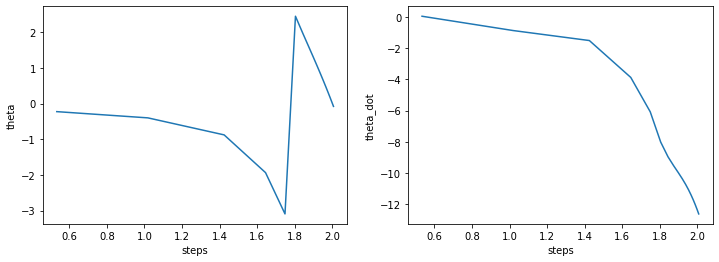

In [15]:
def rad_clip(th):
    r = abs(th)
    while r > np.pi:
        r -= 2 * np.pi
    th = np.sign(th) * r
    return th

l = 5.
env.reset()
states = []
time_limit = 2
time_log = []
acc_time = 0
episode_reward = 0
while True:
    reward = 0
    x = env.state
    states.append([rad_clip(x[0]), x[1]])
    a_agent, tau = ag.forward(x)
    acc_time += tau
    time_log.append(acc_time)
    action_repetition = int(np.ceil(200 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = tau / action_repetition
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        _,_,r,_ = env.step(np.array([a_agent]), dt, tau)
        reward += r
    reward *= dt
    reward += - 0.01 * a_agent**2 + l * tau
    episode_reward += reward
    if acc_time > time_limit:
        break
states = np.array(states)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.xlabel('steps')
plt.ylabel('theta')
plt.plot(time_log, states[:,0])
plt.subplot(1,2,2)
plt.xlabel('steps')
plt.ylabel('theta_dot')
plt.plot(time_log, states[:,1])
plt.show()

In [47]:
print(actor_updates)

NameError: name 'actor_updates' is not defined

In [48]:
class combined_actor(keras2.engine.training.Model):
    def __init__(self, action_net, tau_net):
        """
        Parameters
        ----------
        action_net: Model
        tau_net: Model
        """
        # super().__init__() いるか？
        self.action_net = action_net
        self.tau_net = tau_net
        
    def compile(self):
        pass
    
    def forward(self, observation):
        action = self.action_net.forward(observation)[0]
        tau = self.tau_net.forward(observation)[0]
        
        self_trigger_decision = np.array([action, tau])
        return self_trigger_decision
    
    def backward(self, reward, terminal=False):
        self.action_net.backward(reward, terminal)
        self.tau_net.backward(reward, terminal)
        
    def save_weights(self):
        pass
    
    def load_weights(self):
        pass
    
    def update_target_models_hard(self):
        pass
    
    def reset_states(self):
        pass
    
    def process_state_batch(self, batch):
        pass
        
    
    

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
     
    x1 = Dense(8, activation="relu")(x)
    x1 = Dense(8, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(8, activation="relu")(x)
    x2 = Dense(8, activation="relu")(x2)
    x2 = Dense(1, activation="sigmoid")(x2) # tau
    
    output = Concatenate()([x1, x2])
    
    actor = Model(inputs=action_input, outputs=output)
    actor.summary()
    return actor

def branch_agent(a_shape, s_shape):
    actor = branch_actor(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = selfDDPGAgent(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        clip_com = 0.01
    )
    return agent


b = branch_actor((2,),(2,))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           (None, 1, 2)         0                                            
__________________________________________________________________________________________________
flatten_28 (Flatten)            (None, 2)            0           input_30[0][0]                   
__________________________________________________________________________________________________
dense_154 (Dense)               (None, 8)            24          flatten_28[0][0]                 
__________________________________________________________________________________________________
dense_157 (Dense)               (None, 8)            24          flatten_28[0][0]                 
__________________________________________________________________________________________________
dense_155 

In [36]:
a = np.array([1,2,3,4,5,6,7,8])

action = []
tau = []

for i in range(a.shape[0]):
    if i % 4 < 2:
        action.append(a[i])
    else:
        tau.append(a[i])

print(action, tau)

[1, 2, 5, 6] [3, 4, 7, 8]
